In [2]:
# Import my code
from tensorfactorization.utils import (defactorizing_CP, create_initial_data, random_cp_with_noise)
from tensorfactorization.multiplicative import (tensor_factorization_cp_multiplicative, tensor_factorization_cp_multiplicative_poisson)
from tensorfactorization.poisson import (BacktrackingWarning, tensor_factorization_cp_poisson, tensor_factorization_cp_poisson_fixed_step_size)
from data.data_imports import (load_IL2data, load_indian_pines)#, load_kinetic, load_covid19_serology

from toolkit.constants import (
    picture_folder, data_folder, 
    error_label, iteration_label, tensor_dimension_label, time_label, 
    xscale_convergence_data, xscale_convergence, yscale_convergence
)

%matplotlib widget
import tensorly as tl
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pickle # use pickle to save results to disk
import warnings

from copy import deepcopy

# Create Data

In [ ]:
# Trying do plot many stuff things, you know...
# TODO make this use GPU! For some reason this is super slow on GPU even though it should be very fast?
#tl.set_backend('pytorch')
#context = {'dtype': tl.float32,
#           'device': 'cuda'}
tl.set_backend('numpy')
context = {}

dimensions = []
# add large tensors
for _ in range(50):
    ndim = random.randint(3, 5)
    dimension = []

    max_dimension = 300*300*2
    # TODO make tensor generation smarter so that we dont generate massive ones!
    for n in range(ndim):
        next_dimension = random.randint(3, max( min( int(max_dimension / 3**(ndim-n -1)), 200) , 3 ) )
        dimension.append(next_dimension)
        max_dimension /= next_dimension
        
    dimensions.append(dimension)

# add small tensors
for _ in range(100):
    ndim = random.randint(3, 5)
    dimension = []

    for _ in range(ndim):
        next_dimension = random.randint(3, 12 )
        dimension.append(next_dimension)
        
    dimensions.append(dimension)

# let us also test different sigma values
alpha = 0.5
beta = 0.9
sigmas = [0.5, 0.1, 0.001]

points_for_sigma = {}


for sigma in sigmas:
    print(" \n \n Sigma = " + str(sigma))
    all_points = [] # list containing all points
    
    # big tensors only for now
    for dimension in dimensions:
        print("Dimension of new tensor: " + str(dimension))
        
        F = random.randint(2, 5) # get random order between 2 and 5
        max_iter = random.randint(6, 10) # get a random iteration between 5 and 10 
        scaling = random.uniform(0.1, 100.0) # get a random norm for our tensor
        
        data_of_tensor = []
        
        tensor = random_cp_with_noise(dimension, F, noise_scaling=0.0, context=context) # make it have no noise
        tensor = tensor * scaling
        norm_of_tensor = tl.norm(tensor)

        
        print("doing " + str(max_iter) + " iteration steps, with scaling: " +str(scaling)+" and norm: " + str(norm_of_tensor))

        # creating initial data
        initial_A_ns = create_initial_data(tensor, F)
        #norm_approx = tl.norm( defactorizing_CP(initial_A_ns, tensor.shape) )
        #scaling = (norm_of_tensor / norm_approx) ** (1.0/ tensor.ndim)
        #for n in range(len(initial_A_ns)):
        #    initial_A_ns[n] = initial_A_ns[n] * scaling
        backtracking_failed = False
        with warnings.catch_warnings(record=True) as w:
            # ignore runtimewarnings as they come from stuff that doesnt matter
            warnings.simplefilter("ignore", RuntimeWarning)
            # userwarnings are my warning that backtracking failed
            warnings.simplefilter("always", BacktrackingWarning)
            
            A_ns, _, _, step_size_modfiers = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, sigma=sigma, beta=beta, initial_A_ns=initial_A_ns)
            print("done with factorization")
            
            if w:
                print("Warnings were issued during the function call, skipping tensor")
                if issubclass(warning.category, BacktrackingWarning):
                    print(f"Caught UserWarning: {warning.message}")
                    special_warning_issued = True
                else:
                    # Optionally store or print other captured warnings if you want to see what was ignored
                    print(f"Caught other warning (ignored): {warning.message} ({warning.category.__name__})")

        if backtracking_failed:
            continue
            
        for k in range(2): # always use the 2 last iterations to get bit more data points for free
            for n in range(tensor.ndim):
                khatr_rao_product = tl.tenalg.khatri_rao(A_ns, skip_matrix=n)
                data_of_tensor.append( {
                    "contraction" : khatr_rao_product.shape[0], 
                    "norm" : norm_of_tensor, 
                    "max" : tl.max(tensor),
                    "min" : tl.min(tensor),
                    "mean" : tl.mean(tensor),
                    "step_size" : alpha*math.pow(beta, step_size_modfiers[n][-k]) 
                } )

        # TODO: sort the points by contraction lenght so that plot looks better
        data_of_tensor = sorted(data_of_tensor, key=lambda x : x["contraction"])
        all_points.extend(data_of_tensor) # add the points from this tensor to the list of all points
        contraction_lenghts = [e["contraction"] for e in data_of_tensor]
        step_sizes = [e["step_size"] for e in data_of_tensor]
        plt.plot(contraction_lenghts, step_sizes)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.title("lines Sigma = " + str(sigma))
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # this time do the log ourselfs
    contraction_lenghts = [math.log(e["contraction"]) for e in all_points]
    norms = [e["norm"] for e in all_points]
    step_sizes = [math.log(e["step_size"]) for e in all_points]
    
    ax.scatter(contraction_lenghts, norms, step_sizes)
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    ax.set_xlabel('contraction length')
    ax.set_ylabel('norm of tensor')
    ax.set_zlabel('step size')
    ax.set_title("Sigma = " + str(sigma))
    plt.show()

    points_for_sigma[sigma] = deepcopy(all_points)

try:
    pickle.dump( points_for_sigma, open(data_folder+'optimal_stepsize.pickle', 'wb') )
except Exception as e: print(e)

# Plot Data

In [3]:
def fit_plane(points):
    """
    Fits the best 2D polynomial (plane) of the form z = ax + by + c to a set of 3D points.
    
    Args:
    points: A list or numpy array of 3D points, where each point is represented as [x, y, z].
    
    Returns:
    A tuple (a, b, c) representing the coefficients of the fitted plane.
    Returns None if there are fewer than 3 points.
    """
    points = np.array(points)
    if points.shape[0] < 3:
        print("Error: Need at least 3 points to fit a plane.")
        return None
    
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    
    # Construct the matrix A and vector b for the least squares fit
    # The equation is z = a*x + b*y + c, which can be written as:
    # [x1 y1 1] [a]   [z1]
    # [x2 y2 1] [b] = [z2]
    # ...       [c]   [...]
    A = np.vstack([x, y, np.ones(len(x))]).T
    b = z
    
    # Solve the least squares problem using numpy.linalg.lstsq
    coefficients, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    print("residual was " + str(residuals))
    
    # The coefficients are in the order [a, b, c]
    a, b, c = coefficients
    
    return a, b, c

 
 
 Sigma = 0.5
Now testing norm
residual was [924.75711026]
(-0.8508749421295141, -0.00015065888850671408, -1.214887534145068)
so our formula is: step size = 0.06096947646966617 * length^(-0.8508749421295141) * e^(-0.00015065888850671408 norm)


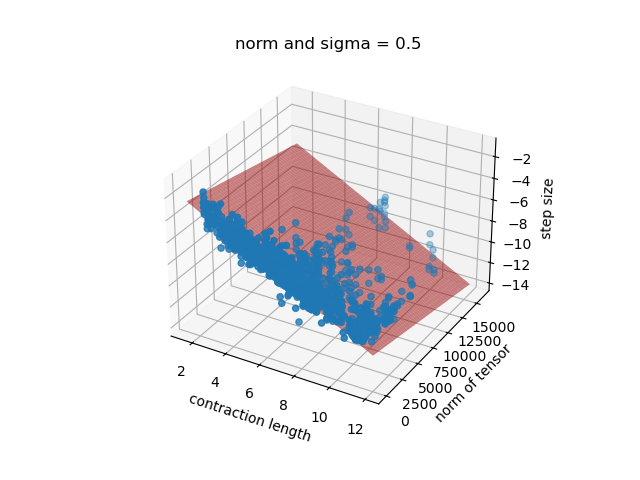

Now testing max
residual was [726.67208115]
(-0.9634201016359085, -0.014297773666951744, 0.05632011954541714)
so our formula is: step size = 1.138466142856029 * length^(-0.9634201016359085) * e^(-0.014297773666951744 max)


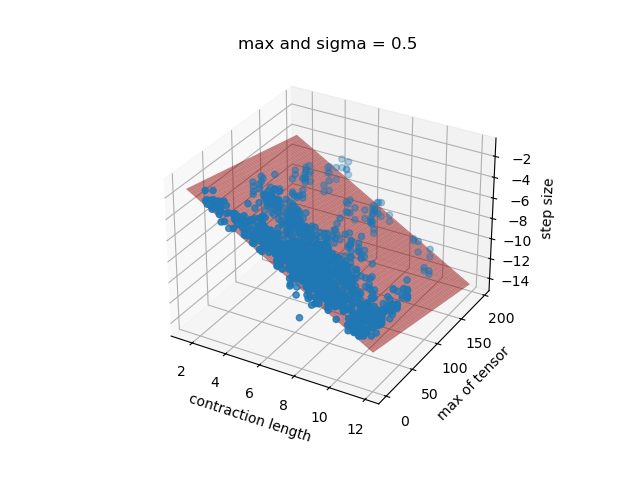

Now testing min
residual was [1052.07797091]
(-0.9746556721880232, -0.1767555255644676, -0.5217250660907992)
so our formula is: step size = 0.300797992793698 * length^(-0.9746556721880232) * e^(-0.1767555255644676 min)


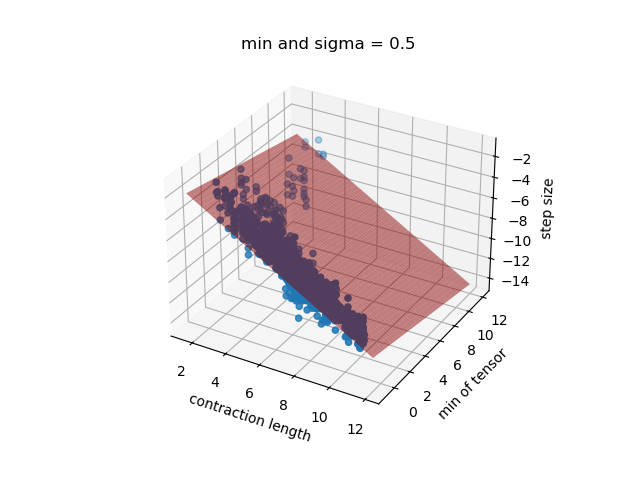

Now testing mean
residual was [830.41833415]
(-1.0164885739222438, -0.04539841125598677, 0.16841609584168132)
so our formula is: step size = 1.4737237952423372 * length^(-1.0164885739222438) * e^(-0.04539841125598677 mean)


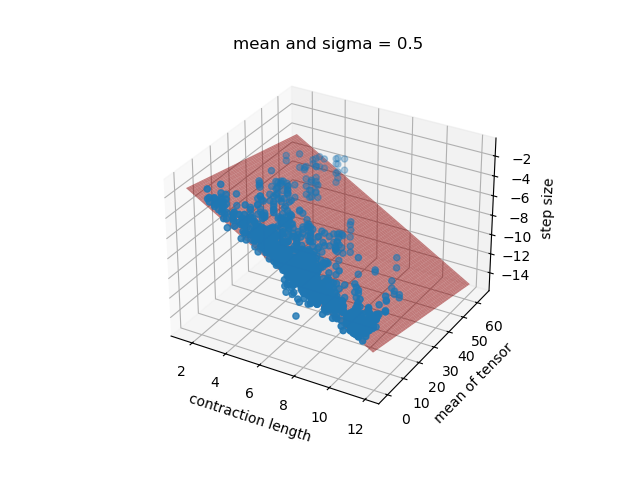

 
 
 Sigma = 0.1
Now testing norm
residual was [973.42119639]
(-0.8618045290062533, -0.0001400043027999315, -0.7914551455211424)
so our formula is: step size = 0.1616385159772754 * length^(-0.8618045290062533) * e^(-0.0001400043027999315 norm)


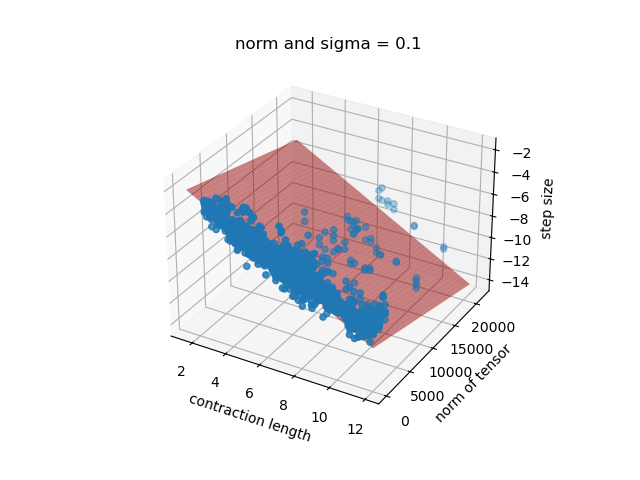

Now testing max
residual was [756.42306542]
(-0.9273586896054711, -0.014576707019494, 0.112809132636704)
so our formula is: step size = 1.296609301069122 * length^(-0.9273586896054711) * e^(-0.014576707019494 max)


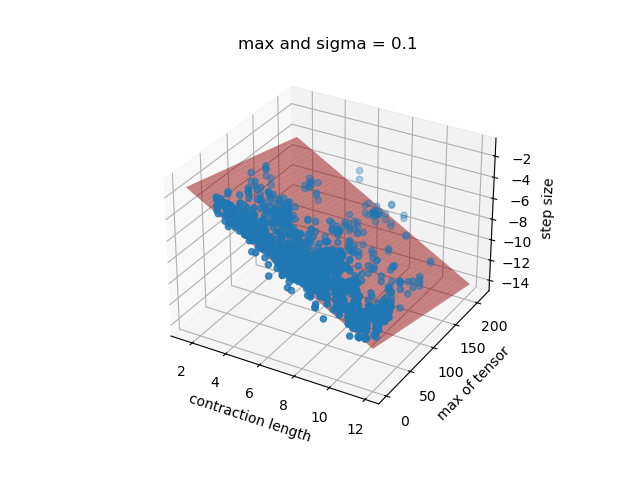

Now testing min
residual was [1156.9064669]
(-0.9673870650632616, -0.09809872352749005, -0.25872362495107487)
so our formula is: step size = 0.551158329347674 * length^(-0.9673870650632616) * e^(-0.09809872352749005 min)


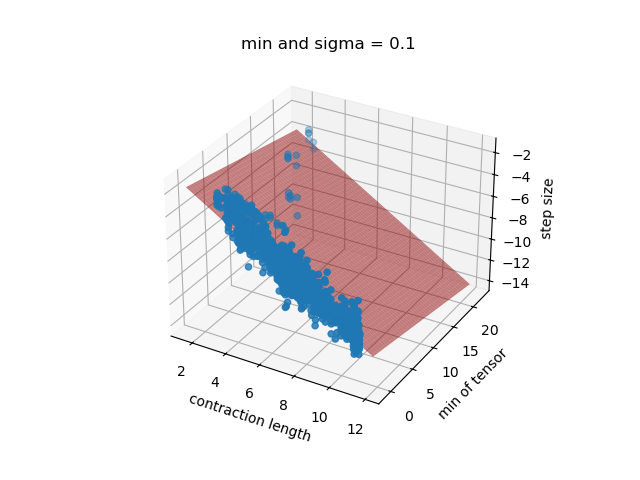

Now testing mean
residual was [872.77841583]
(-1.002879540596367, -0.04606119555847285, 0.3986519602732916)
so our formula is: step size = 2.504101683946396 * length^(-1.002879540596367) * e^(-0.04606119555847285 mean)


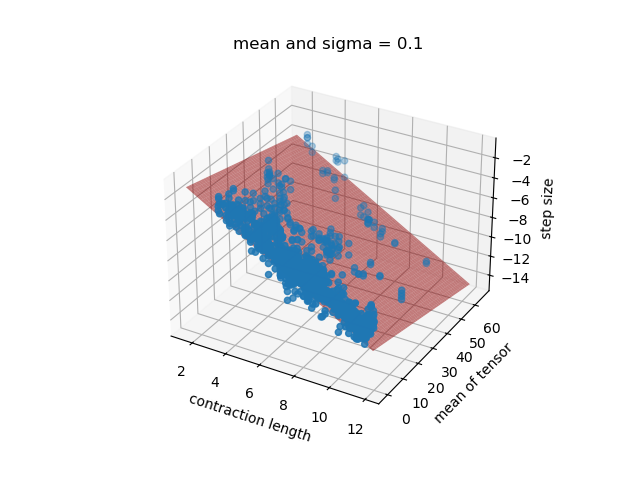

 
 
 Sigma = 0.001
Now testing norm
residual was [1319.68811778]
(-0.8146726211681127, -0.00021167895015370352, -1.0158201632747503)
so our formula is: step size = 0.09642282176154349 * length^(-0.8146726211681127) * e^(-0.00021167895015370352 norm)


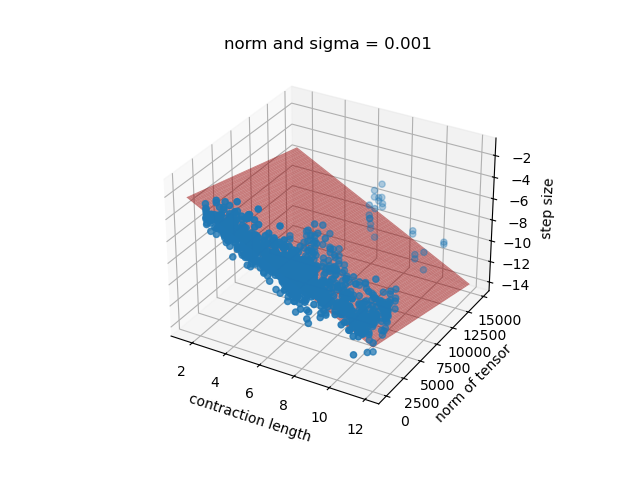

Now testing max
residual was [1109.41254986]
(-0.940747584712839, -0.01824728627820204, 0.3749145311257759)
so our formula is: step size = 2.3709070667628724 * length^(-0.940747584712839) * e^(-0.01824728627820204 max)


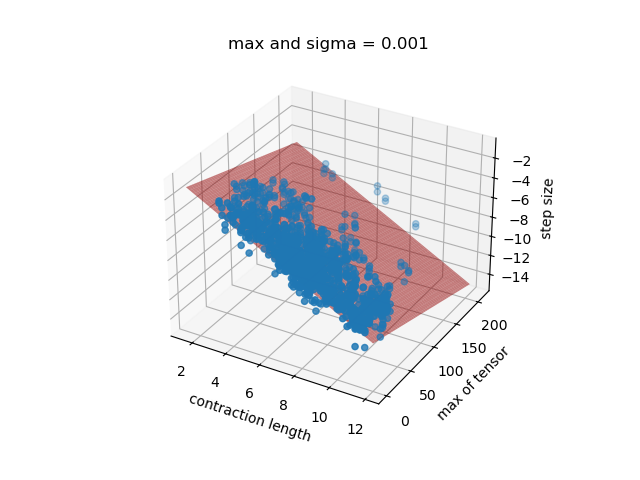

Now testing min
residual was [1535.2899731]
(-0.9428075109179695, -0.12294357595425309, -0.39472812045346983)
so our formula is: step size = 0.40296922450593614 * length^(-0.9428075109179695) * e^(-0.12294357595425309 min)


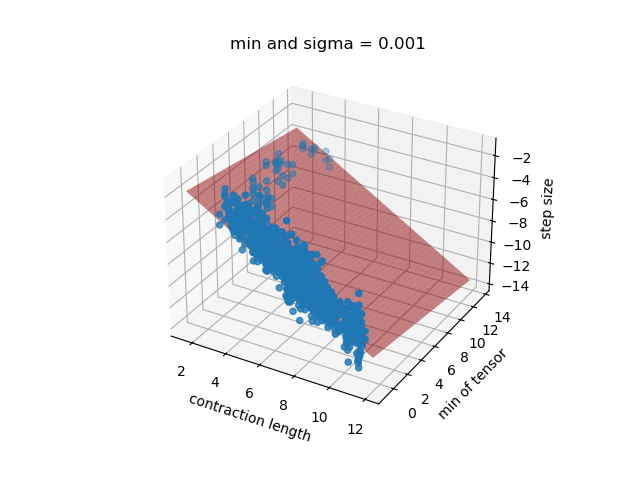

Now testing mean
residual was [1249.65517066]
(-1.0087848402731412, -0.057529223820963815, 0.5542592896352091)
so our formula is: step size = 3.58310297562664 * length^(-1.0087848402731412) * e^(-0.057529223820963815 mean)


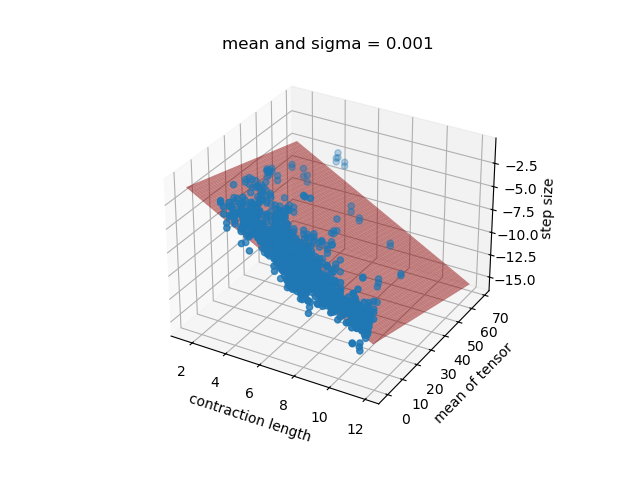

In [4]:
file = open(data_folder+"optimal_stepsize.pickle",'rb')
points_for_sigma = pickle.load(file)
file.close()

# iterate over all sigmas and print and plot the data
for sigma, all_points in points_for_sigma.items():
    print(" \n \n Sigma = " + str(sigma))
    
    contraction_lenghts = [math.log(e["contraction"]) for e in all_points]
    scaling_types = {
        "norm" : [e["norm"] for e in all_points],
        "max" : [e["max"] for e in all_points],
        "min" : [e["min"] for e in all_points],
        "mean" : [e["mean"] for e in all_points],
    }
    step_sizes = [math.log(e["step_size"]) for e in all_points]

    for name, data in scaling_types.items():
        print("Now testing " + name)
        
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(contraction_lenghts, data, step_sizes)
        #ax.set_xscale('log')
        #ax.set_yscale('log')
    
        ax.set_xlabel('contraction length')
        ax.set_ylabel(name+' of tensor')
        ax.set_zlabel('step size')
        ax.set_title(name+" and sigma = " + str(sigma))
        #plt.show()
    
        # let us now find the best 1d line through these points in loglog
        points = [(math.log(p["contraction"]), p[name], math.log(p["step_size"])) for p in all_points]
        coefficients = fit_plane(points)
        print(coefficients)
        # recalculate to exponential formula
        print("so our formula is: step size = "+str(math.pow(10, coefficients[2]))+" * length^("+str(coefficients[0])+") * e^("+str(coefficients[1])+" "+name+")")
        #p = np.poly1d(z)
        #xp = np.linspace(min(x)-1, max(x)+1, 100)
        
        #_ = plt.plot(x, y, '.', xp, p(xp), '-')
        #plt.title("Sigma = " + str(sigma))
        a, b, c = coefficients
        xp = np.linspace(min(contraction_lenghts)-1, max(contraction_lenghts)+1, 100)
        yp = np.linspace(min(data)-1, max(data)+1, 100)
        X, Y = np.meshgrid(xp, yp)
        Z = a * X + b * Y + c
        ax.plot_surface(X, Y, Z, color='red', alpha=0.5, label='Fitted Plane')
        plt.show()

# Testing on India Pines

In [11]:
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}

print("\nTesting on indian pines data:")
indian_pines = load_indian_pines()
tensor = tl.tensor(indian_pines.tensor, **context)
tensor = tensor*100.0
#tensor = tensor / tl.max(tensor)
print("Tensor is of shape: " + str(tensor.shape)+" with min: "+str(tl.min(tensor))+", max: "+str(tl.max(tensor))+", average: "+str(tl.mean(tensor)))
F = 4 # TODO find good F here
# generate initial A_ns
initial_A_ns = create_initial_data(tensor, F)

tensor_factorization_cp_poisson(tensor,F,max_iter=3,verbose=True, initial_A_ns=initial_A_ns)


Testing on indian pines data:
Tensor is of shape: torch.Size([145, 145, 200]) with min: tensor(95500., device='cuda:0'), max: tensor(960400., device='cuda:0'), average: tensor(265238.9375, device='cuda:0')
Current index: 0
Initial m = 17
Biggest element in -gradient: tensor(1.4619e+08, device='cuda:0')
smallest element in -gradient: tensor(-21132168., device='cuda:0')
Time from start to calculate gradients and first next iterate: 0.10106086730957031
Time from start until end of step size calculation: 0.23111867904663086
Step Size: 1.4901161193847656e-08
m: 25
Step size * biggest element: tensor(2.1784, device='cuda:0')
biggest element in A_n: tensor(82.2256, device='cuda:0')
smallest element in A_n: tensor(0.3250, device='cuda:0')
Shape of approximated_X_unfolded_n: torch.Size([145, 29000])
Shape of khatri Rao product: torch.Size([29000, 4])
Calculculation time: 0.23611855506896973
New objective function value: tensor(-1.2641e+13, device='cuda:0')
function_value_at_iteration = tensor(

[tensor([[ 48.3878,  16.0952,  50.0360,  46.5963],
         [ 62.0744,  58.6326,  13.3421,  48.8358],
         [  7.7630,  59.1335,  38.0683,  59.2756],
         [ 31.8604,  59.4977,  41.0822,  21.9553],
         [ 27.5717,  51.8317,  50.4974,  52.4710],
         [ 56.8221,  35.9979,  45.3262,  38.5508],
         [  3.0089,  79.1658,  28.2115,  49.1463],
         [ 97.3780,  24.9865,  55.5545,  63.3517],
         [ 60.9068,  37.1227,  55.4225,  49.7199],
         [ 58.1500,  43.5225,  55.7218,   6.6077],
         [ 59.5715,  58.7019,   0.4134,  66.4591],
         [ 25.3362,  55.6126,  69.0299,   9.5530],
         [ 59.8298,  53.7667,  45.2293,  45.3304],
         [ 41.9231,  45.1707,   2.6310,  64.9068],
         [ 39.6666,   1.1350,  30.7200,  92.5162],
         [ 43.5349,  12.3999,  50.2174,  52.8042],
         [ 41.5742,  25.8799,  37.3553,  63.0836],
         [ 33.8232,  21.8577,  64.4714,  48.2040],
         [ 36.5008,  10.7780,  72.4422,  51.5690],
         [ 54.5067,  27.6191,  